In [ ]:
# # Cell 1: 导入必要库
# import pandas as pd
# import numpy as np
# from scipy.spatial.transform import Rotation as R
# import matplotlib.pyplot as plt


# # Cell 2: 定义计算 yaw 的函数
# def compute_yaw(quat_array: np.ndarray, seq: str, degrees: bool = True) -> np.ndarray:
#     """
#     计算 yaw（第一个 Euler 分量）：
#       seq: 'zyx' → extrinsic；'ZYX' → intrinsic
#       返回 shape = (N,) 的 yaw（度数或弧度）
#     """
#     rot = R.from_quat(quat_array)  # 期望 [x, y, z, w]
#     eulers = rot.as_euler(seq, degrees=degrees)
#     return eulers[:, 0]


# # Cell 3: 读取数据、计算两种 yaw 并展示统计
# # 调整下面路径到你的文件
# csv_path = '/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/bno_test/customEntValHere/2025_05_09/11_00_52/My_V4_Miniscope/headOrientation.csv'

# # 读取
# df = pd.read_csv(csv_path)

# # 提取四元数并重排为 SciPy 要求的 [x,y,z,w]
# quat = df[['qx','qy','qz','qw']].to_numpy()

# # 计算 yaw
# df['yaw_extrinsic'] = compute_yaw(quat, 'zyx', True)
# df['yaw_intrinsic'] = compute_yaw(quat, 'ZYX', True)

# # 计算 Δ = max–min
# delta_ext = df['yaw_extrinsic'].max() - df['yaw_extrinsic'].min()
# delta_int = df['yaw_intrinsic'].max() - df['yaw_intrinsic'].min()

# print(f"Extrinsic yaw Δ = {delta_ext:.2f}°")
# print(f"Intrinsic yaw Δ = {delta_int:.2f}°")




Extrinsic yaw Δ = 353.86°
Intrinsic yaw Δ = 205.18°


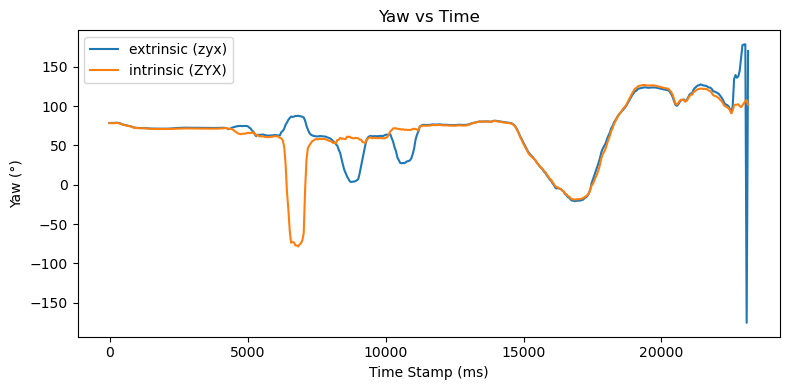

In [ ]:
# ### prob wrong
# # Cell 5: 绘图对比
# plt.figure(figsize=(8,4))
# plt.plot(df['Time Stamp (ms)'], df['yaw_extrinsic'], label='extrinsic (zyx)')
# plt.plot(df['Time Stamp (ms)'], df['yaw_intrinsic'], label='intrinsic (ZYX)')
# plt.xlabel('Time Stamp (ms)')
# plt.ylabel('Yaw (°)')
# plt.legend()
# plt.title('Yaw vs Time')
# plt.tight_layout()
# plt.show()


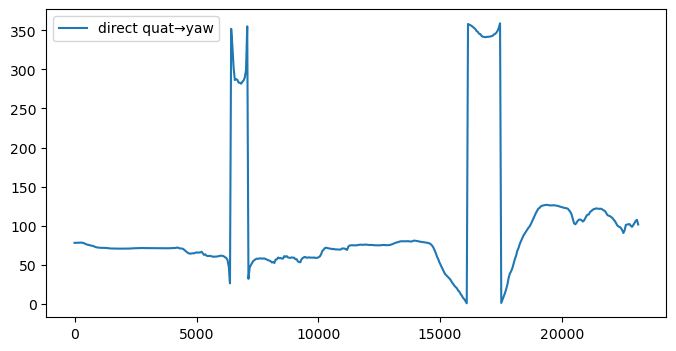

In [ ]:
# ### prob wrong

# # quat_array: N×4 的 [qx, qy, qz, qw] numpy 数组
# def quat2yaw(quat_array: np.ndarray) -> np.ndarray:
#     x, y, z, w = quat_array.T
#     yaw = np.degrees(
#         np.arctan2(2*(w*z + x*y),
#                    w*w + x*x - y*y - z*z)
#     ) % 360
#     return yaw

# df['yaw_direct'] = quat2yaw(quat)
# plt.figure(figsize=(8,4))
# plt.plot(df['Time Stamp (ms)'], df['yaw_direct'], label='direct quat→yaw')
# plt.legend(); plt.show()


In [ ]:
# # 对 extrinsic seq 举例
# eulers_ext = R.from_quat(quat).as_euler('zyx', degrees=True)
# df['yaw_ext'], df['pitch_ext'], df['roll_ext'] = eulers_ext[:,0], eulers_ext[:,1], eulers_ext[:,2]

# # 筛选：pitch、roll 都小于 5°
# mask = (df['pitch_ext'].abs()<5) & (df['roll_ext'].abs()<5)
# pure = df[mask]
# print("纯 yaw 段 Δ yaw ≈", pure['yaw_ext'].max() - pure['yaw_ext'].min())


纯 yaw 段 Δ yaw ≈ nan


In [9]:
# Cell 1: 准备环境
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401
from matplotlib.animation import FuncAnimation

# Cell 2: 读数据 & 转 Rotation 对象
csv_path = '/data/big_rim/rsync_dcc_sum/Oct3V1mini_sorted/bno_test/customEntValHere/2025_05_09/11_00_52/My_V4_Miniscope/headOrientation.csv'

df = pd.read_csv(csv_path)
quat = df[['qx','qy','qz','qw']].to_numpy()  # SciPy 期望 [x,y,z,w] 顺序
rots = R.from_quat(quat)                     # N 帧的 Rotation 序列
times = df['Time Stamp (ms)'].to_numpy()

# Cell 3: 定义立方体顶点和棱线
# 一个边长为 1，中心在原点的立方体
verts = np.array([
    [-0.5,-0.5,-0.5],
    [ 0.5,-0.5,-0.5],
    [ 0.5, 0.5,-0.5],
    [-0.5, 0.5,-0.5],
    [-0.5,-0.5, 0.5],
    [ 0.5,-0.5, 0.5],
    [ 0.5, 0.5, 0.5],
    [-0.5, 0.5, 0.5],
])
# 按顶点索引画出 12 条棱
edges = [
    (0,1),(1,2),(2,3),(3,0),
    (4,5),(5,6),(6,7),(7,4),
    (0,4),(1,5),(2,6),(3,7),
]

# Cell 4: 初始化 3D 画布
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-1,1); ax.set_ylim(-1,1); ax.set_zlim(-1,1)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
lines = [ax.plot([],[],[], 'k-')[0] for _ in edges]

# Cell 5: 每帧更新函数
def update_frame(i):
    Rm = rots[i].as_matrix()  # 3×3
    pts = verts @ Rm.T        # N×3
    for line, (u,v) in zip(lines, edges):
        xs, ys, zs = pts[[u,v],0], pts[[u,v],1], pts[[u,v],2]
        line.set_data(xs, ys)
        line.set_3d_properties(zs)
    ax.set_title(f"t = {times[i]} ms")
    return lines

# Cell 6: 生成并显示动画（或保存为 MP4）
ani = FuncAnimation(fig, update_frame, frames=len(rots),
                    interval=20, blit=True)
plt.close(fig)  # 防止 notebook 自动绘原点
# 要在 notebook 里直接看：
# from IPython.display import HTML
# HTML(ani.to_jshtml())

# —— 或者，保存成文件 —— 
ani.save('orientation_anim.mp4', dpi=200, fps=20, writer='ffmpeg')


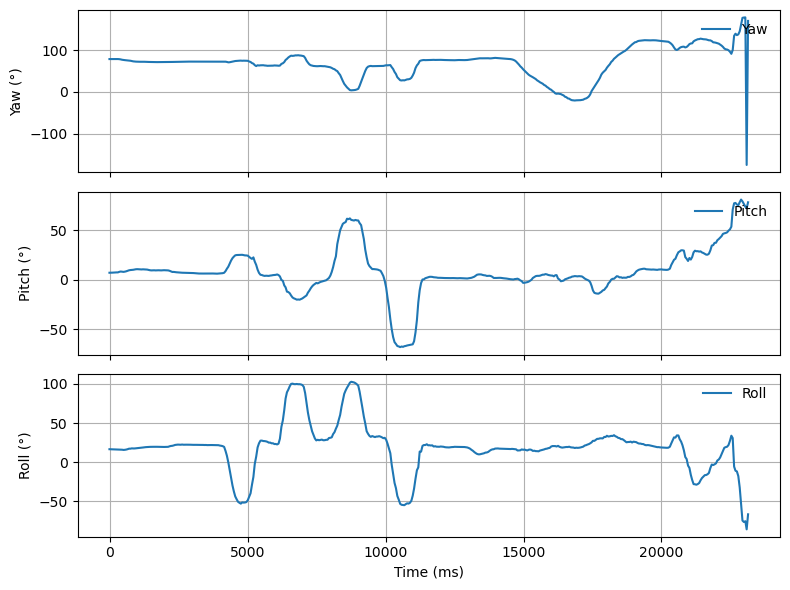

In [10]:
# Cell 7: 计算并绘制 Euler 角
# —————————————————————————————————————————————
# 1. 提取 Euler 角（°），顺序为 [yaw, pitch, roll]
euler_angles = rots.as_euler('zyx', degrees=True)  # shape (N,3)
yaw   = euler_angles[:, 0]
pitch = euler_angles[:, 1]
roll  = euler_angles[:, 2]

# 2. 绘图
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axes[0].plot(times, yaw,   label='Yaw')   # 绕 Z 轴
axes[1].plot(times, pitch, label='Pitch') # 绕 Y 轴
axes[2].plot(times, roll,  label='Roll')  # 绕 X 轴

# 3. 美化
axes[0].set_ylabel('Yaw (°)')
axes[1].set_ylabel('Pitch (°)')
axes[2].set_ylabel('Roll (°)')
axes[2].set_xlabel('Time (ms)')
for ax in axes:
    ax.grid(True)
    ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()


In [11]:
from scipy.spatial.transform import Rotation as R

# 1) Pure yaw of +30° about Z
r_yaw30   = R.from_euler('z', 30, degrees=True)
print("Yaw test:", r_yaw30.as_euler('zyx', degrees=True))   # → [30,  0,  0]

# 2) Pure pitch of +20° about Y
r_pitch20 = R.from_euler('y', 20, degrees=True)
print("Pitch test:", r_pitch20.as_euler('zyx', degrees=True)) # → [ 0, 20,  0]

# 3) Pure roll of +10° about X
r_roll10  = R.from_euler('x', 10, degrees=True)
print("Roll test:", r_roll10.as_euler('zyx', degrees=True))  # → [ 0,  0, 10]


Yaw test: [30.  0. -0.]
Pitch test: [ 0. 20. -0.]
Roll test: [ 0.  0. 10.]


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 23 14:01:45 2022

@author: 13190044511
"""
import os
import numpy as np
import scipy.io as sio
import imageio
import tqdm
from projection import *
import connectivity

import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter

def find_calib_file(base_folder):
    for file_name in os.listdir(base_folder):
        if file_name.endswith('label3d_dannce.mat'):
            return os.path.join(base_folder, file_name)
    return None
# /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_06_26/1686940_left/DANNCE/predict_results/six_points_multi_test_0calib
# /hpc/group/tdunn/lq53/dannce_chris_calib/240503rec_240229V1left/result_folder/train_newcom_70frames_100epo/DANNCE/predict_results
###############################################################################################################
base_path =  "/data/big_rim/rsync_dcc_sum/25Apri_social/2025_05_02/1shank3KOM_boxedshank3KOF"
#'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17' #'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35' #'/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_13/20240910v1r_cricket_cyliner_test_16_17'
cammm = 3
video_path = os.path.join(base_path, f'videos/Camera{cammm}/0.mp4')
label3d_path = find_calib_file(base_path)
pred_folder = 'DANNCE/predict00'
# label3d_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_06_28/1686941_left_right_2/pos_synced_1686941_left_right_2_2024_06_28_1686941_left_label3d_dannce.mat' #calib
pred_path = os.path.join(base_path, pred_folder, 'save_data_AVG.mat') #  smoothed_prediction_AVG0.mat
N_FRAMES = 100
START_FRAME = 0
ANIMAL= 'mouse20' #'mouse22'
cam = f'Camera{cammm}' 
vid_title = f'combined_cam{cammm}_{N_FRAMES}_after{START_FRAME}' #after500
VID_NAME = vid_title + '.mp4'
COLOR = connectivity.COLOR_DICT[ANIMAL]
CONNECTIVITY = connectivity.CONNECTIVITY_DICT[ANIMAL]
save_path = os.path.join(base_path, pred_folder, 'vis') #os.path.join(pred_path, 'vis')
if not os.path.exists(save_path):
    os.makedirs(save_path)

com_file = os.path.join(base_path,pred_folder,'com3d_used.mat')
com_data = sio.loadmat(com_file)
###############################################################################################################
# load camera parameterss
cameras = load_cameras(label3d_path)